## Coding up a Color Selection

Check out the code below. First, I import **pyplot** and **image** from **matplotlib**. I also import **numpy** for operating on the image.

### set up an environment in Windows 10

> conda install -c https://conda.anaconda.org/menpo opencv3

> pip install moviepy

> conda install -c jithinpr2 pango

In [5]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
%matplotlib inline

I then read in an image and print out some stats. I’ll grab the x and y sizes and make a copy of the image to work with.

('This image is: ', <type 'numpy.ndarray'>, 'with dimensions:', (540, 960, 3))


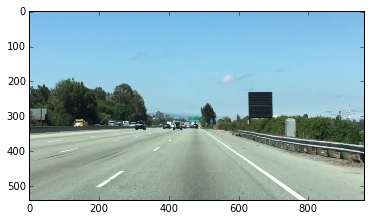

In [16]:
# Read in the image and print out some stats
image = mpimg.imread('test.jpg')
print('This image is: ', type(image), 'with dimensions:', image.shape)
plt.imshow(image)

# Grab the x and y size and make a copy of the image
ysize = image.shape[0]
xsize = image.shape[1]
color_select = np.copy(image)

Next I define a color threshold in the variables red_threshold, green_threshold, and blue_threshold and populate rgb_threshold with these values. This vector contains the minimum values for red, green, and blue (R,G,B) that I will allow in my selection.

In [13]:
# Define our color selection criteria
red_threshold = 200
green_threshold = 200
blue_threshold = 200
rgb_threshold = [red_threshold, green_threshold, blue_threshold]

Next, I'll use a bitwise OR to select any pixels below the threshold and set them to zero.

After that, all pixels that meet my color criterion will be retained, and those that do not will be blacked out.

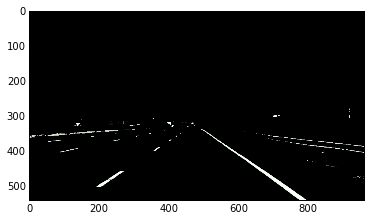

In [14]:
# Use a "bitwise OR" to identify pixels below the threshold
thresholds = (image[:,:,0] < rgb_threshold[0]) \
            | (image[:,:,1] < rgb_threshold[1]) \
            | (image[:,:,2] < rgb_threshold[2])
color_select[thresholds] = [0,0,0]

# Display the image                 
plt.imshow(color_select)

The result, color_select, is an image in which pixels that were above the threshold have been retained, and pixels below the threshold have been blacked out.

In the code snippet above, red_threshold, green_threshold and blue_threshold are all set to 0, which implies all pixels will be included in the selection.

In the next quiz, you will modify the values of red_threshold, green_threshold and blue_threshold until you retain as much of the lane lines as possible while dropping everything else. Your output image should look like the one below.

## Coding up a Region of Interest Mask
Now you've seen that with a simple color selection we have managed to eliminate almost everything in the image except the lane lines.

At this point, however, it would still be tricky to extract the exact lines automatically, because we still have some other objects detected around the periphery that aren't lane lines.

In this case, I'll assume that the front facing camera that took the image is mounted in a fixed position on the car, such that the lane lines will always appear in the same general region of the image. Next, I'll take advantage of this by adding a criterion to only consider pixels for color selection in the region where we expect to find the lane lines.

Check out the code below. The variables **left_bottom**, **right_bottom**, and **apex** represent the vertices of a triangular region that I would like to retain for my color selection, while masking everything else out.

('This image is: ', <type 'numpy.ndarray'>, 'with dimesions:', (540, 960, 3))


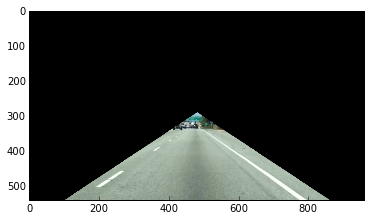

In [23]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

# Read in the image and print some stats
image = mpimg.imread('test.jpg')
print('This image is: ', type(image), 
         'with dimesions:', image.shape)

# Pull out the x and y sizes and make a copy of the image
ysize = image.shape[0]
xsize = image.shape[1]
region_select = np.copy(image)

# Define a triangle region of interest 
cpoint = 20
bpoint = 100
left_bottom = [0+bpoint, ysize]
right_bottom = [xsize-bpoint, ysize]
apex = [round(xsize/2), round(ysize/2)+cpoint]


# Fit lines (y=Ax+B) to identify the  3 sided region of interest
# np.polyfit() returns the coefficients [A, B] of the fit
fit_left = np.polyfit((left_bottom[0], apex[0]), 
                      (left_bottom[1], apex[1]), 1)
fit_right = np.polyfit((right_bottom[0], apex[0]), 
                       (right_bottom[1], apex[1]), 1)
fit_bottom = np.polyfit((left_bottom[0], right_bottom[0]), 
                        (left_bottom[1], right_bottom[1]), 1)

# Find the region inside the lines
XX, YY = np.meshgrid(np.arange(0, xsize), np.arange(0, ysize))
region_thresholds = (YY > (XX*fit_left[0] + fit_left[1])) & \
                    (YY > (XX*fit_right[0] + fit_right[1])) & \
                    (YY < (XX*fit_bottom[0] + fit_bottom[1]))

# Find where image is both colored right and in the region
region_select[~region_thresholds] = [0, 0, 0]

# Display the image
plt.imshow(region_select)

## Combining Color and Region Selections

Now you've seen how to mask out a region of interest in an image. Next, let's combine the mask and color selection to pull only the lane lines out of the image.

Check out the code below. Here we’re doing both the color and region selection steps, requiring that a pixel meet both the mask and color selection requirements to be retained.

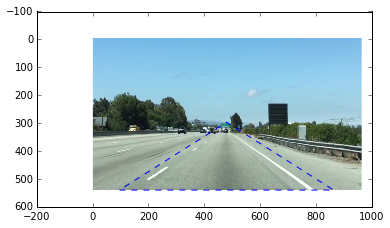

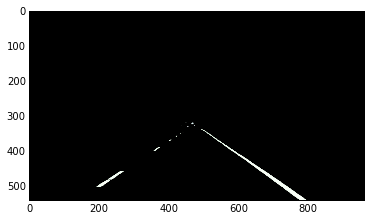

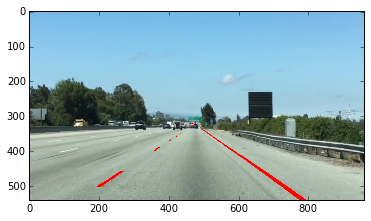

In [51]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

# Read in the image
image = mpimg.imread('test.jpg').astype('uint8')

# Grab the x and y sizes and make two copies of the image
ysize = image.shape[0]
xsize = image.shape[1]
color_select= np.copy(image)
line_image = np.copy(image)

# Define our color criteria
red_threshold = 200
green_threshold = 200
blue_threshold = 200
rgb_threshold = [red_threshold, green_threshold, blue_threshold]

# Define a triangle region of interest (Note: if you run this code, 
cpoint = 0.55
wpoint = 0.1
left_bottom = [round(xsize*wpoint), ysize]
right_bottom = [round(xsize*(1-wpoint)), ysize]
apex = [round(xsize/2), round(ysize*cpoint)]

fit_left = np.polyfit((left_bottom[0], apex[0]), 
                      (left_bottom[1], apex[1]), 1)
fit_right = np.polyfit((right_bottom[0], apex[0]), 
                       (right_bottom[1], apex[1]), 1)
fit_bottom = np.polyfit((left_bottom[0], right_bottom[0]), 
                        (left_bottom[1], right_bottom[1]), 1)

# Perform a "bitwise or" to mask pixels below the threshold
color_thresholds = (image[:,:,0] < rgb_threshold[0]) | \
                    (image[:,:,1] < rgb_threshold[1]) | \
                    (image[:,:,2] < rgb_threshold[2])

# Find the region inside the lines
XX, YY = np.meshgrid(np.arange(0, xsize), np.arange(0, ysize))
region_thresholds = (YY > (XX*fit_left[0] + fit_left[1])) & \
                    (YY > (XX*fit_right[0] + fit_right[1])) & \
                    (YY < (XX*fit_bottom[0] + fit_bottom[1]))
# Mask color selection
color_select[color_thresholds | ~region_thresholds] = [0,0,0]
# Color pixels red where both color right and region selections met
line_image[~color_thresholds & region_thresholds] = [255,0,0]

# Display the image and show region and color selections
plt.figure()
plt.imshow(image)
x = [left_bottom[0], right_bottom[0], apex[0], left_bottom[0]]
y = [left_bottom[1], right_bottom[1], apex[1], left_bottom[1]]
plt.plot(x, y, 'b--', lw=1)
plt.figure()
plt.imshow(color_select)
plt.figure()
plt.imshow(line_image)

## Canny Edge Detecion in Action

Now that you have a conceptual grasp on how the Canny algorithm works, it's time to use it to find the edges of the lane lines in an image of the road. So let's give that a try.

First, we need to read in an image:

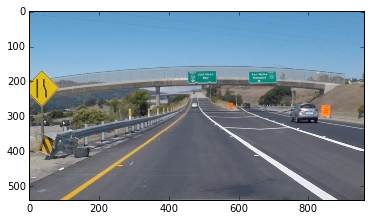

In [54]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
image = mpimg.imread('exit-ramp.png')
plt.imshow(image)

Here we have an image of the road, and it's fairly obvious by eye where the lane lines are, but what about using computer vision?

Let's go ahead and convert to grayscale.

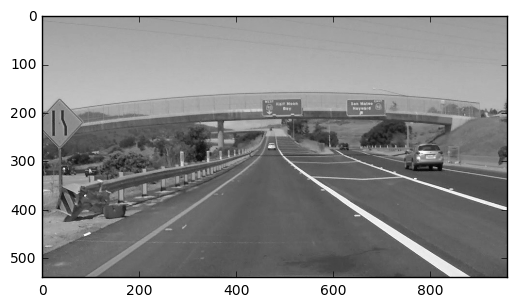

In [34]:
import cv2  #bringing in OpenCV libraries
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) #grayscale conversion
plt.imshow(gray, cmap='gray')

Let’s try our Canny edge detector on this image. This is where OpenCV gets useful. First, we'll have a look at the parameters for the OpenCV Canny function. You will call it like this:

In [ ]:
edges = cv2.Canny(gray, low_threshold, high_threshold)

In this case, you are applying Canny to the image gray and your output will be another image called edges. low_threshold and high_threshold are your thresholds for edge detection.

The algorithm will first detect strong edge (strong gradient) pixels above the **high_threshold**, and reject pixels below the **low_threshold**. Next, pixels with values between the low_threshold and high_threshold will be included as long as they are connected to strong edges. The output edges is a binary image with white pixels tracing out the detected edges and black everywhere else. See the [OpenCV Canny Docs](http://docs.opencv.org/2.4/doc/tutorials/imgproc/imgtrans/canny_detector/canny_detector.html) for more details.

What would make sense as a reasonable range for these parameters? In our case, converting to grayscale has left us with an 8-bit image, so each pixel can take 28 = 256 possible values. Hence, the pixel values range from 0 to 255.

This range implies that derivatives (essentially, the value differences from pixel to pixel) will be on the scale of tens or hundreds. So, a reasonable range for your threshold parameters would also be in the tens to hundreds.

As far as a ratio of low_threshold to high_threshold, [John Canny himself recommended](http://docs.opencv.org/2.4/doc/tutorials/imgproc/imgtrans/canny_detector/canny_detector.html#steps) a low to high ratio of 1:2 or 1:3.

We'll also include Gaussian smoothing, before running Canny, which is essentially a way of suppressing noise and spurious gradients by averaging (check out the [OpenCV docs for GaussianBlur](http://docs.opencv.org/2.4/modules/imgproc/doc/filtering.html?highlight=gaussianblur#gaussianblur)). You can choose the kernel_size for Gaussian smoothing to be any odd number. A larger kernel_size implies averaging, or smoothing, over a larger area. The example in the previous lesson was kernel_size = 3.

Note: If this is all sounding complicated and new to you, don't worry! We're moving pretty fast through the material here, because for now we just want you to be able to use these tools. If you would like to dive into the math underpinning these functions, please check out the free Udacity course, [ntro to Computer Vision](https://www.udacity.com/course/introduction-to-computer-vision--ud810?_ga=1.71516183.502510602.1473749403), where the third lesson covers Gaussian filters and the sixth and seventh lessons cover edge detection.

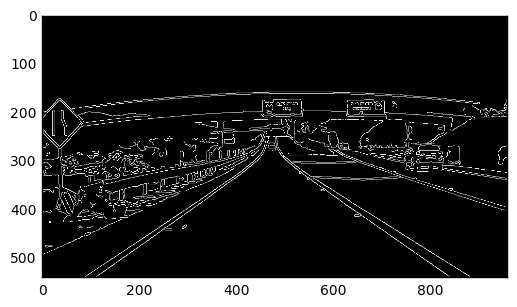

In [36]:
#doing all the relevant imports
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2

# Read in the image and convert to grayscale
image = (mpimg.imread('exit-ramp.png')*255).astype('uint8')
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

# Define a kernel size for Gaussian smoothing / blurring
kernel_size = 5
blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size), 0)

# Define parameters for Canny and run it
# NOTE: if you try running this code you might want to change these!
ratio = 2
value = 60
low_threshold = value
high_threshold = value*ratio
edges = cv2.Canny(blur_gray, low_threshold, high_threshold)

# Display the image
plt.imshow(edges, cmap='Greys_r')

Here I've called the OpenCV function Canny on a Gaussian-smoothed grayscaled image called blur_gray and detected edges with thresholds on the gradient of high_threshold, and low_threshold.

In the next quiz you'll get to try this on your own and mess around with the parameters for the Gaussian smoothing and Canny Edge Detection to optimize for detecting the lane lines and not a lot of other stuff.

## Using the Hough Transform to Find Lines from Canny Edges

In image space, a line is plotted as x vs. y, but in 1962, Paul Hough devised a method for representing lines in parameter space, which we will call “Hough space” in his honor.

In Hough space, I can represent my "x vs. y" line as a point in "m vs. b" instead. The Hough Transform is just the conversion from image space to Hough space. So, the characterization of a line in image space will be a single point at the position (m, b) in Hough space.

So now I’d like to check your intuition… if a **line** in image space corresponds to a **point** in Hough space, what would **two parallel lines** in image space correspond to in Hough space?

![](22-q-hough-intro-quiz.png)

Ans: C

Alright, so a line in image space corresponds to a point in Hough space. What does a point in image space correspond to in Hough space?

A single point in image space has many possible lines that pass through it, but not just any lines, only those with particular combinations of the m and b parameters. Rearranging the equation of a line, we find that a single point (x,y) corresponds to the line b = y - xm.

So what is the representation of a point in image space in Hough space?

![](23-q-hough-second-quiz.png)

Ans: C (That's right! A point in image space describes a line in Hough space. So a line in an image is a point in Hough space and a point in an image is a line in Hough space… cool!)

What if you have **2 points** in image space. What would that look like in Hough space?

![](23-q-hough-second-quiz-copy.png)

Ans: C (That's correct! Two points in image space correspond to two lines in Hough Space. Not only that, but these lines must intersect… why?)

Alright, now we have two intersecting lines in Hough Space. How would you represent their **intersection** at the point (m0, b0) in image space?

![](25-q-hough-fourth-quiz.png)

Ans: A
That's right! The intersection point at (m0, b0) represents the line y = m0x + b0 in image space and it must be the line that passes through both points!

So this is how we’re going to find lines!

Suppose I’ve run my Canny Edge Detection Algorithm to find all points associated with edges in an image.

I can then consider every point in this edge detected image as a line in Hough space. And where many lines in Hough space intersect, I declare I have found a line in image space!

The strategy here is to divide up our Hough space into a grid, and define intersecting lines as all lines passing through a given grid cell.

We have a problem though… vertical lines have infinite slope in (m, b) representation, in which case we need a new parameterization (i.e. a new set of coordinates). So, let’s redefine our line in [polar coordinates](https://en.wikipedia.org/wiki/Polar_coordinate_system), where we use angle (Θ) and distance (ρ) from the origin to define lines. (FYI: Θ is the Greek letter theta and ρ is the Greek letter rho.)

With polar coordinates, each **point** in image space now corresponds to a **sine curve** in Hough space.

So, if we translate many points from image space to polar coordinate Hough space, we'll find many sine curves. The intersection of those sine curves in (Θ, ρ) Hough space gives the parameterization of a line, just like the intersection of straight lines in (m, b) Hough space gave us the parameterization of a lines.
What happens if we run a Hough Transform on an image of a square? What will the corresponding plot in Hough space look like?

![](26-q-hough-fifth-quiz.png)

Ans: C
That's right! The four major intersections between curves in Hough space correspond to the four sides of the square.

Now you know how the Hough Transform works, but to accomplish the task of finding lane lines, we need to specify some parameters to say what kind of lines we want to detect (i.e., long lines, short lines, bendy lines, dashed lines, etc.). To do this, we'll be using an OpenCV function called **HoughLinesP** that takes several parameters.

## Implementing a Hough Transform on Edge Detected Image

Now that you know how the Hough Transform works, we're going to code it up and find the lane lines in the image we detected edges in with the Canny function.

Here's the image we're working with:

![](edges-exitramp.jpg)

Let's look at the input parameters for the OpenCV function HoughLinesP that we will use to find lines in the image. You will call it like this:

> lines = cv2.HoughLinesP(edges, rho, theta, threshold, np.array([]), min_line_length, max_line_gap)

In this case, we are operating on the image **edges** (the output from **Canny**) and the output from **HoughLinesP** will be **lines**, which will simply be an array containing the endpoints (x1, y1, x2, y2) of all line segments detected by the transform operation. The other parameters define just what kind of line segments we're looking for.

First off, **rho** and **theta** are the distance and angular resolution of our grid in Hough space. Remember that, in Hough space, we have a grid laid out along the (Θ, ρ) axis. You need to specify rho in units of pixels and theta in units of radians.

So, what are reasonable values? Well, rho takes a minimum value of 1, and a reasonable starting place for theta is 1 degree (pi/180 in radians). Scale these values up to be more flexible in your definition of what constitutes a line.

The **threshold** parameter specifies the minimum number of votes (intersections in a given grid cell) a candidate line needs to have to make it into the output. The empty **np.array([])** is just a placeholder, no need to change it. **min_line_length** is the minimum length of a line (in pixels) that you will accept in the output, and **max_line_gap** is the maximum distance (again, in pixels) between segments that you will allow to be connected into a single line. You can then iterate through your output lines and draw them onto the image to see what you got!

So, here's what its going to look like:

(540, 960, 3)


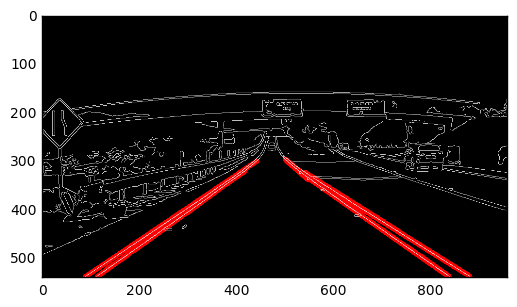

In [64]:
# Do relevant imports
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

# Read in and grayscale the image
image = (mpimg.imread('exit-ramp.png')*255).astype('uint8')
gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)

# Define a kernel size and apply Gaussian smoothing
kernel_size = 5
blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size),0)

# Define our parameters for Canny and apply
low_threshold = 50
high_threshold = 150
edges = cv2.Canny(blur_gray, low_threshold, high_threshold)

# Next we'll create a masked edges image using cv2.fillPoly()
mask = np.zeros_like(edges)   
ignore_mask_color = 255   

# This time we are defining a four sided polygon to mask
imshape = image.shape
print(imshape)

cpoint = 0.55
offset = 30
vertices = np.array([[(0,imshape[0]),
                      (round(imshape[1]/2)-offset, round(imshape[0]*cpoint)), 
                      (round(imshape[1]/2)+offset, round(imshape[0]*cpoint)), 
                      (imshape[1],imshape[0])]], dtype=np.int32)
#vertices = np.array([[(0,imshape[0]),(450, 290), (490, 290), (imshape[1],imshape[0])]], dtype=np.int32)
cv2.fillPoly(mask, vertices, ignore_mask_color)
masked_edges = cv2.bitwise_and(edges, mask)


# Define the Hough transform parameters
# Make a blank the same size as our image to draw on
rho = 2 # distance resolution in pixels of the Hough grid
theta = np.pi/180 # angular resolution in radians of the Hough grid
threshold = 15     # minimum number of votes (intersections in Hough grid cell)
min_line_length = 40 #minimum number of pixels making up a line
max_line_gap = 20    # maximum gap in pixels between connectable line segments
line_image = np.copy(image)*0 # creating a blank to draw lines on

# Run Hough on edge detected image
lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold, np.array([]),
                            min_line_length, max_line_gap)

# Iterate over the output "lines" and draw lines on the blank
for line in lines:
    for x1,y1,x2,y2 in line:
        cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),10)

# Create a "color" binary image to combine with line image
color_edges = np.dstack((edges, edges, edges)) 

# Draw the lines on the edge image
combo = cv2.addWeighted(color_edges, 0.8, line_image, 1, 0) 
plt.imshow(combo)

As you can see I've detected lots of line segments! Your job, in the next exercise, is to figure out which parameters do the best job of optimizing the detection of the lane lines. Then, you'll want to apply a region of interest mask to filter out detected line segments in other areas of the image. When you're finished you'll be ready to apply the skills you've learned to do the project at the end of this lesson.

## Finding Lane Lines in a Video Stream

### Project Instructions

To get started on the project, download or **git clone** [the project repository on GitHub](https://github.com/udacity/CarND-LaneLines-P1). You'll find the instructions in the README file. Click "Next" below to view the project evaluation rubric and submission details.